In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model

In [6]:
!aws s3 cp s3://ocean-eddy-data-nasa/oceaneddy_data/ data --recursive
# print(os.path.abspath(os.getcwd()))

In [7]:
data_path = ('data')
os.chdir(data_path)
print(os.path.abspath(os.getcwd()))

/home/ec2-user/SageMaker/data


In [8]:
train_file = 'label.csv'
train_data = pd.read_csv(train_file)

In [9]:
# print(train_data)

In [10]:
x = train_data["label"].value_counts()
# print(x)
last = x.index[-1]
first = x.index[0]
x = x.rename(index={last: 'noneddy'})
x = x.rename(index={first: 'eddy'})
# print(x)

<AxesSubplot:title={'center':'number of image files for eddy vs noneddy'}>

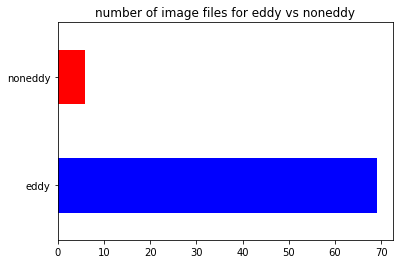

In [11]:
x.plot(kind='barh', color = ['b', 'r'], title="number of image files for eddy vs noneddy") ##, ylabel = "number of files for analysis"

In [12]:
###The stratified k fold cross-validation is an extension of the cross-validation technique used for classification problems. 
###It maintains the same class ratio throughout the K folds as the ratio in the original dataset.

In [13]:
Y = train_data[['label']]
n = len(Y)

In [74]:
kf = KFold(n_splits = 5) # , random_state=7, shuffle=True
# skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
batch_size = 8

In [75]:
# # this is the augmentation configuration we will use for training
idg_train = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False) ## cannot do flip
idg_test = ImageDataGenerator(rescale=1./255)

In [76]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [77]:
class my_model():
    def __init__(self):
        super(my_model, self).__init__()

        self.model = models.Sequential()
        self.model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        self.model.add(layers.MaxPooling2D((2, 2)))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(8, activation='relu'))
        self.model.add(layers.Dense(1, activation='sigmoid'))
        # plot_model(self.model, to_file='model_plot11.png', show_shapes=True, show_layer_names=True)

    def create_new_model(self):
        return self.model

In [82]:
VALIDATION_ACCURACY = []
# VALIDATION_LOSS = []

save_dir = '/saved_models/'
fold_var = 1

model_class = my_model()
for train_index, val_index in kf.split(np.zeros(n),Y): ## for stratified use skf instead of kf
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]

    train_data_generator = idg_train.flow_from_dataframe(training_data.astype(str), directory = './eddy_data_last',
                x_col = "filename", y_col = "label",        
                target_size=(256, 256),  
                color_mode = 'grayscale',        
                batch_size=batch_size,
                class_mode = "categorical", shuffle = True)

    valid_data_generator  = idg_test.flow_from_dataframe(validation_data.astype(str), directory = './eddy_data_last',
            x_col = "filename", y_col = "label",    
            target_size=(256, 256),        
            color_mode = 'grayscale',        
            batch_size=1,        
            class_mode='categorical')

    # CREATE NEW MODEL
    model = model_class.create_new_model()
    model.compile(loss='binary_crossentropy', ## squared_hinge or ##hinge ##binary_crossentropy ##sparse_categorical_crossentropy
    optimizer='adam', ##'rmsprop', ## sgd
    metrics=['accuracy'])

    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
            monitor='val_accuracy', verbose=1, 
            save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    history = model.fit(
    train_data_generator,
    steps_per_epoch = 400 // batch_size,
    epochs=5,
    validation_data=valid_data_generator,
    validation_steps = 40 // batch_size)

    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names,results))
    
#     print(model.metrics_names)
    print(results['accuracy'])
    
    VALIDATION_ACCURACY.append(results['accuracy'])
#     VALIDATION_LOSS.append(results['loss'])
        
    tf.keras.backend.clear_session()

    fold_var += 1

Found 60 validated image filenames belonging to 1 classes.
Found 15 validated image filenames belonging to 2 classes.
Epoch 1/5
15/15 [==============================] - 0s 11ms/step - loss: 1.2484 - accuracy: 0.5000
0.5
Found 60 validated image filenames belonging to 2 classes.
Found 15 validated image filenames belonging to 1 classes.
Epoch 1/5
15/15 [==============================] - 0s 11ms/step - loss: 0.6926 - accuracy: 1.0000
1.0
Found 60 validated image filenames belonging to 2 classes.
Found 15 validated image filenames belonging to 1 classes.
Epoch 1/5
15/15 [==============================] - 0s 11ms/step - loss: 0.6930 - accuracy: 1.0000
1.0
Found 60 validated image filenames belonging to 2 classes.
Found 15 validated image filenames belonging to 1 classes.
Epoch 1/5
15/15 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.0000e+00
0.0
Found 60 validated image filenames belonging to 2 classes.
Found 15 validated image filenames belonging to 1 classes

In [83]:
avg = sum(VALIDATION_ACCURACY)/5
print("The average accuracy from all folds is: "+str(avg*100)+'%')

The average accuracy from all folds is: 70.0%
